In [2]:
import sys
import pandas as pd
from load_data import get_data, load_pkl, save_pkl
from processing_helpers import get_cue_segments, get_power_spec, get_peak_fits, get_control_segments
from tally_helper import TallyWindow
# from plot_window import plot_processing
import pickle as pkl
import numpy as np
import DataProcessingTools as DPT
import os
import matplotlib.pyplot as plt
from fooof import FOOOF
from ipywidgets import widgets, HBox, VBox, Output
from scipy.stats import sem, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [7]:
# Global variables to store the session data
lfp_df = pd.DataFrame()
ch_num_list = []
lfp_mne = []
session_start_time = 0
markers = []
timeStamps = []
sampling_frequency = 0
cue_segments_df = pd.DataFrame()
control_segments_df = pd.DataFrame()

In [13]:
def load_data(day):
    """
    Load LFP data for a given day.
    """
    global lfp_df, ch_num_list, lfp_mne, session_start_time, markers, timeStamps, sampling_frequency
    print(f"Loading data for {day}...")
    lfp_df, ch_num_list, lfp_mne, session_start_time, markers, timeStamps, sampling_frequency = get_data(day)

    if lfp_df is not None:
        print(f"Loaded {len(ch_num_list)} channels.")
        print(lfp_df.head())
    else:
        print("Failed to load data.")



In [14]:
# Load Raw Data
day = "20181105"
load_data(day)

# Extract segments with a specific window size and process
window_size = 1000  # e.g., 1000 ms
peak_fit_range = [1,14]


cue_segments_df = load_pkl("Data Processed/20181105_1s_welch.pkl")
control_segments_df = load_pkl("Data Processed/control_segments.pkl")


Loading data for 20181105...
Creating RawArray with float64 data, n_channels=26, n_times=5496020
    Range : 0 ... 5496019 =      0.000 ...  5496.019 secs
Ready.
Loaded 26 channels.
  channel                                           lfp_data
0     009  [-15.689277, -63.415035, -97.32542, -110.48099...
1     019  [-7.3521805, -22.254305, -32.18146, -35.23267,...
2     021  [-7.631544, -1.5259957, 3.660045, 8.1869755, 1...
3     022  [-56.752617, -77.27964, -92.39461, -100.60819,...
4     023  [32.315643, 41.446926, 46.777287, 46.48198, 41...
Data successfully loaded from Data Processed/20181105_1s_welch.pkl
Loaded data has 10374 rows and 14 columns.
                                             segment channel start_position  \
0  [-4.5271883, -1.9674453, 9.442836, 25.153576, ...     009             34   
1  [-42.301697, -45.33196, -43.950962, -39.873737...     019             34   
2  [-76.19089, -30.659563, 20.823097, 73.89416, 1...     021             34   
3  [-80.23443, -129.71568,

In [17]:
cue_segments_df.keys()

Index(['segment', 'channel', 'start_position', 'cue_onset', 'psd', 'freq',
       'peak_stds', 'peak_means', 'peak_gauss', 'flat_specs', 'flat_spec_og',
       'ap_fit_og', 'peaks', 'peak_freqs'],
      dtype='object')

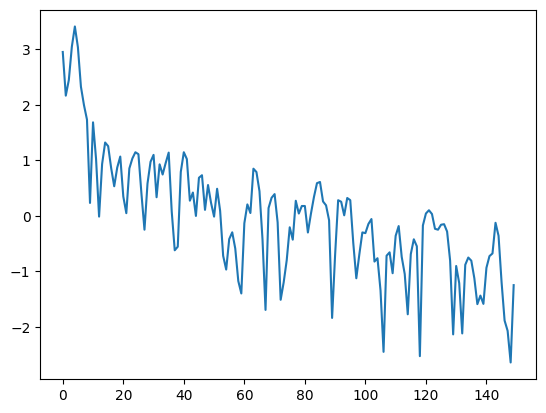

In [18]:
plt.plot(cue_segments_df['psd'][0])

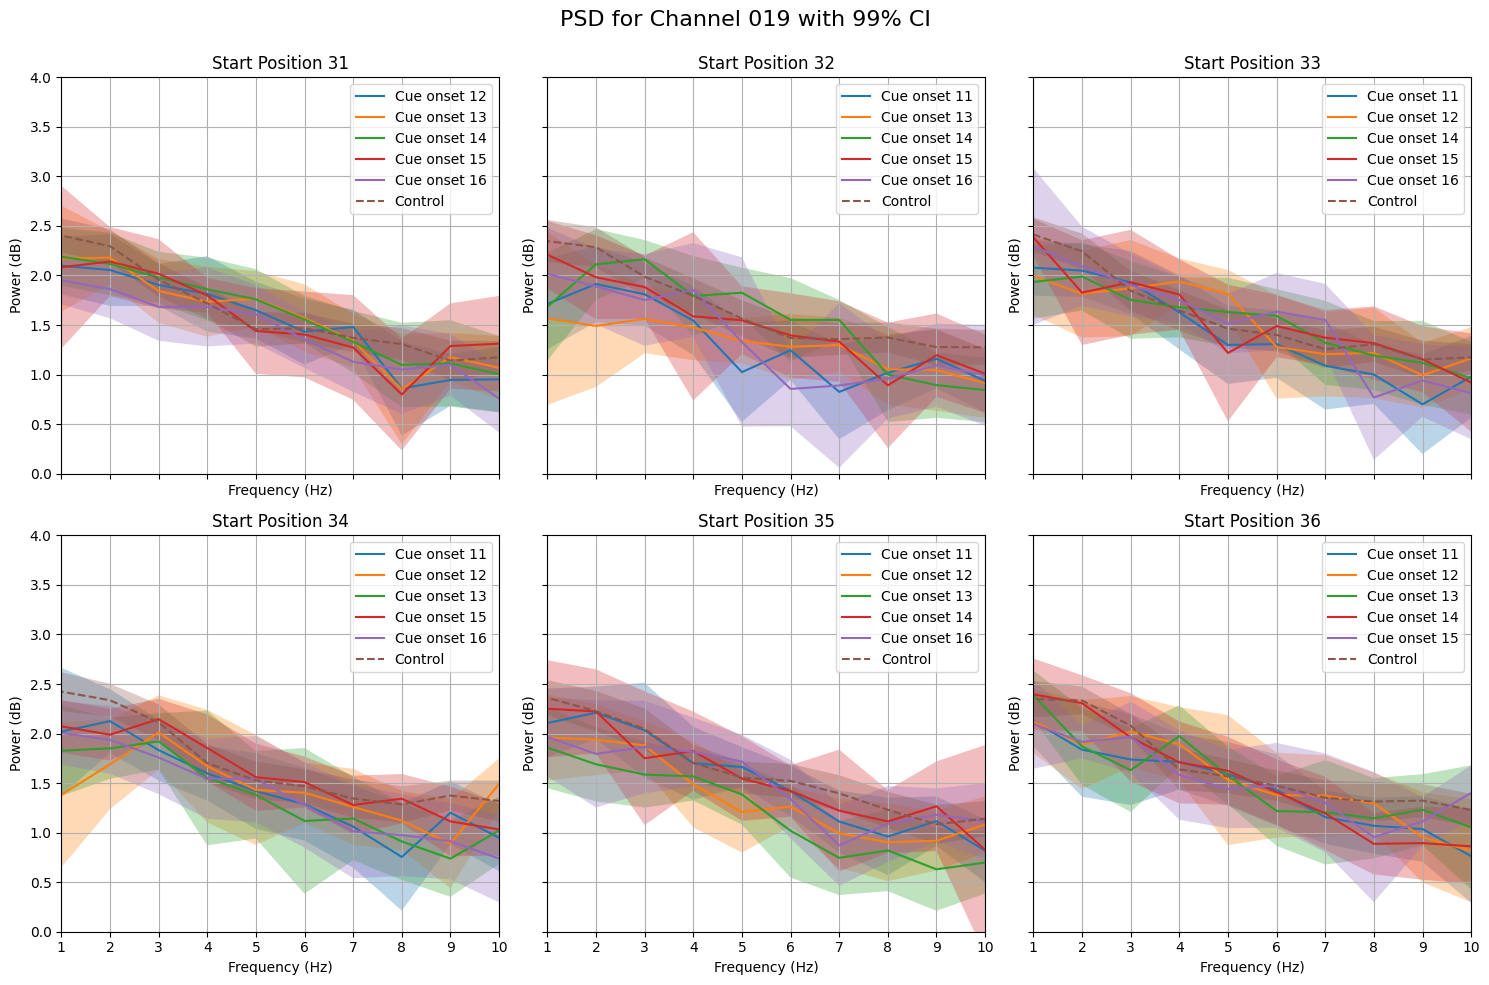

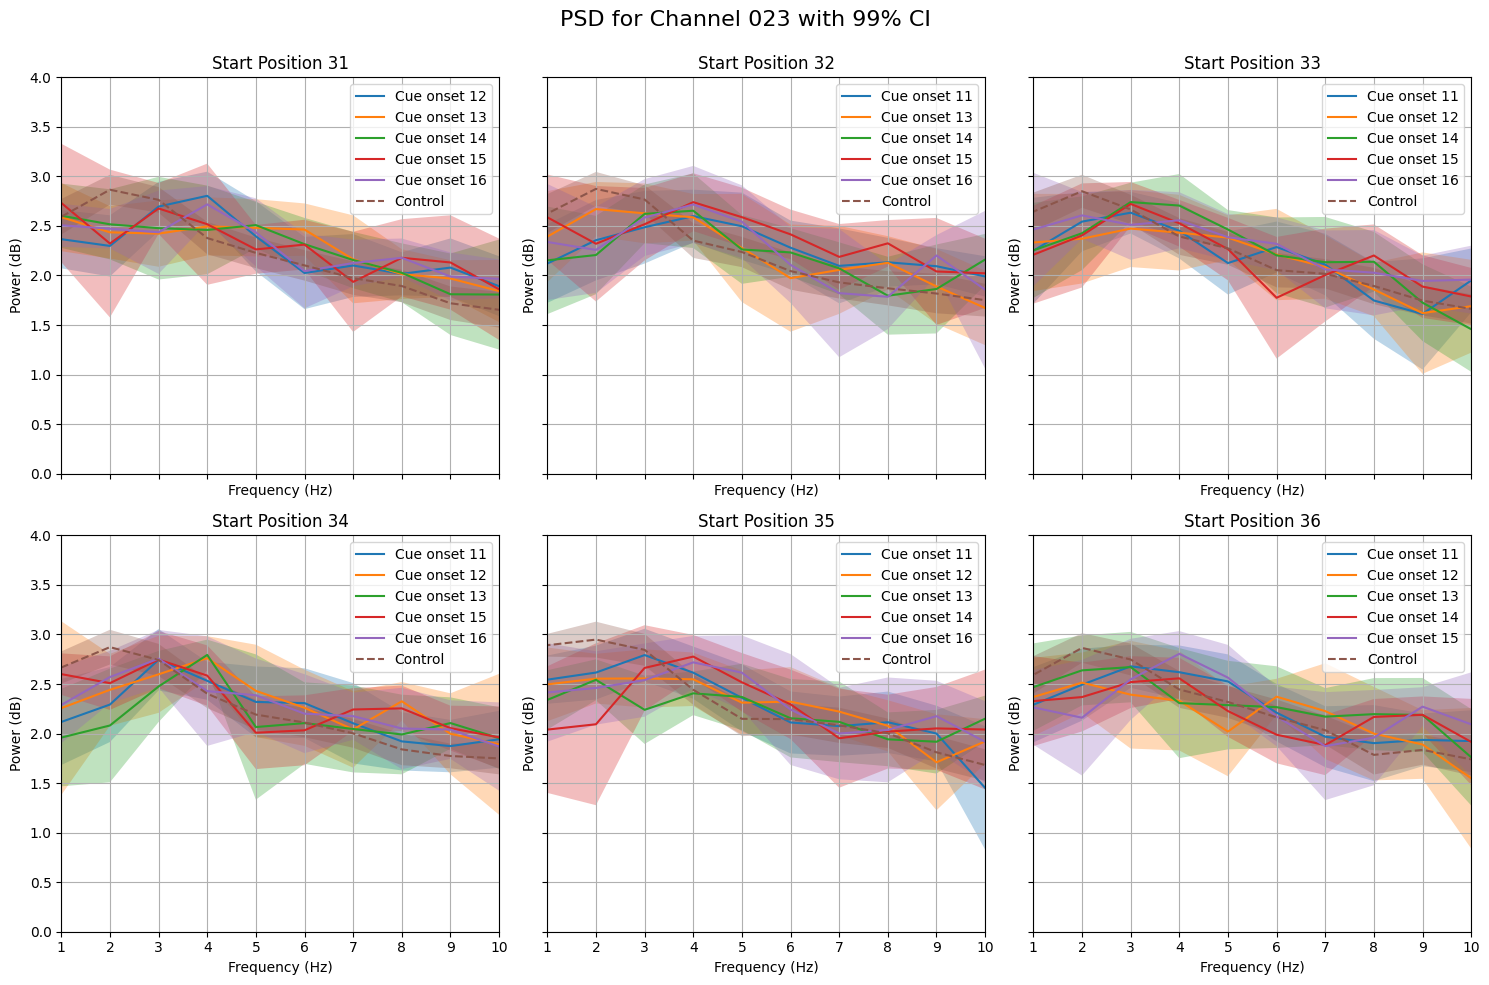

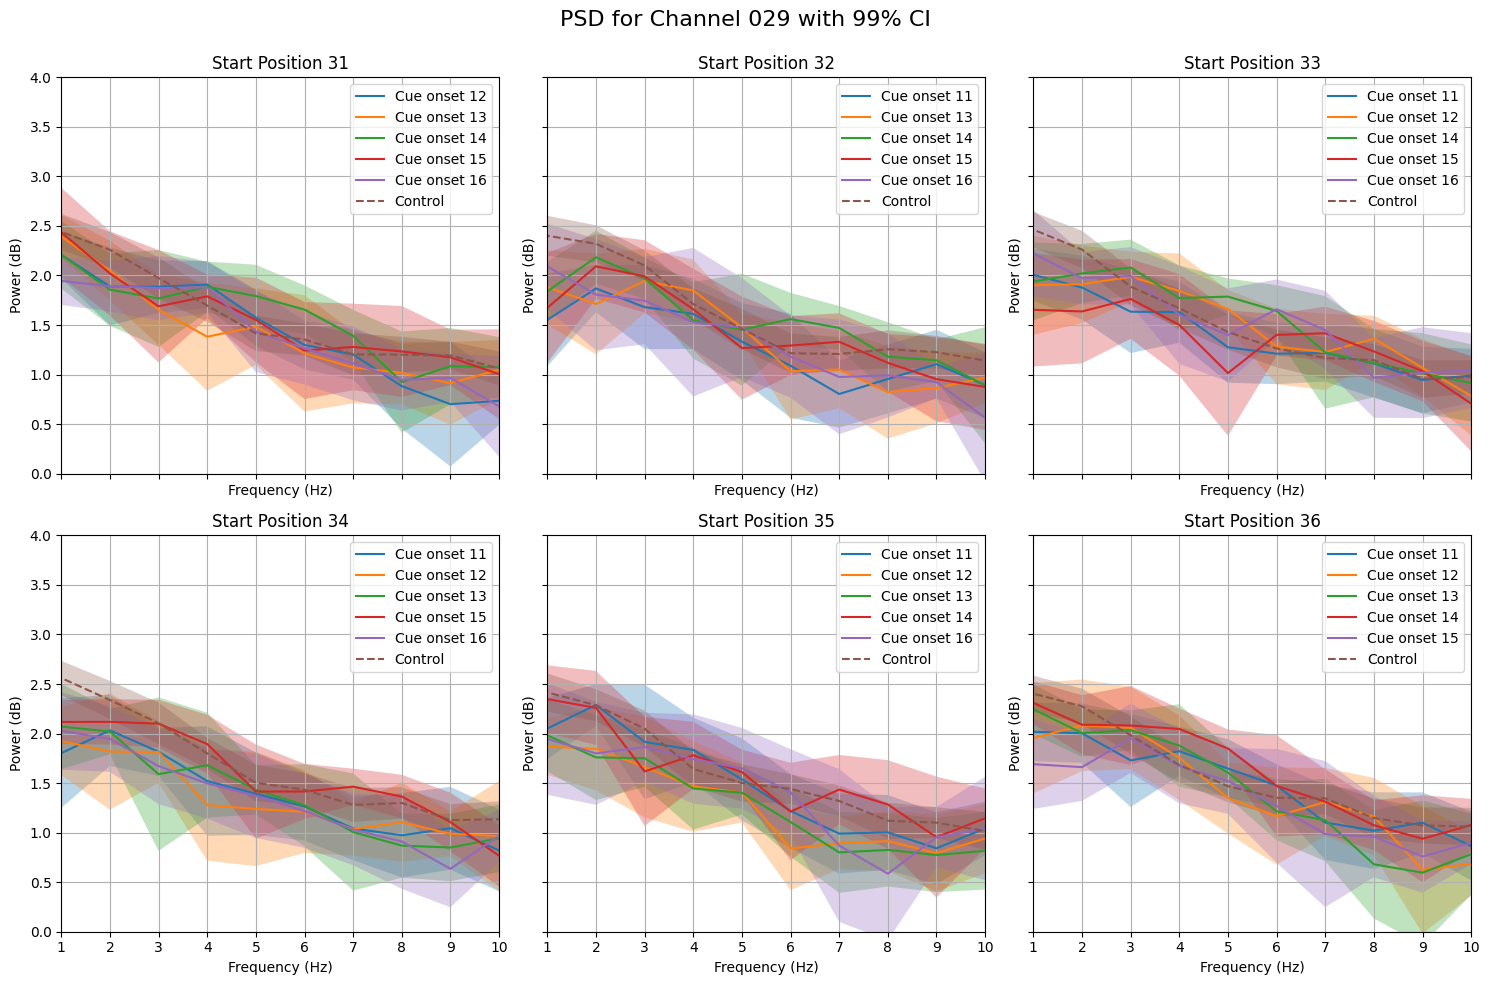

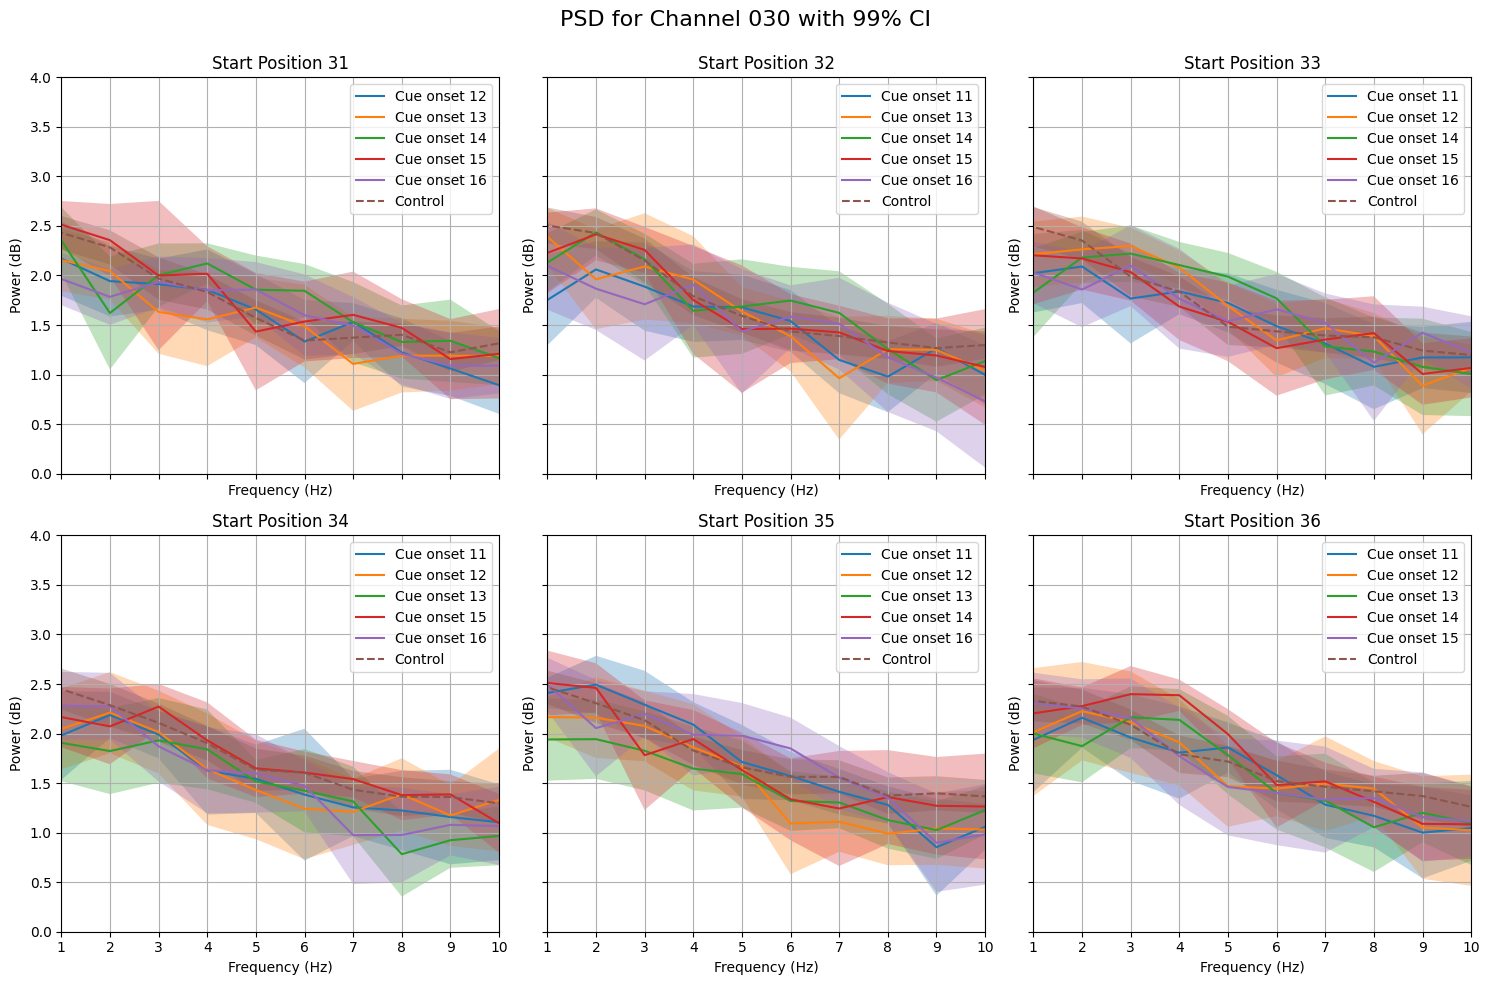

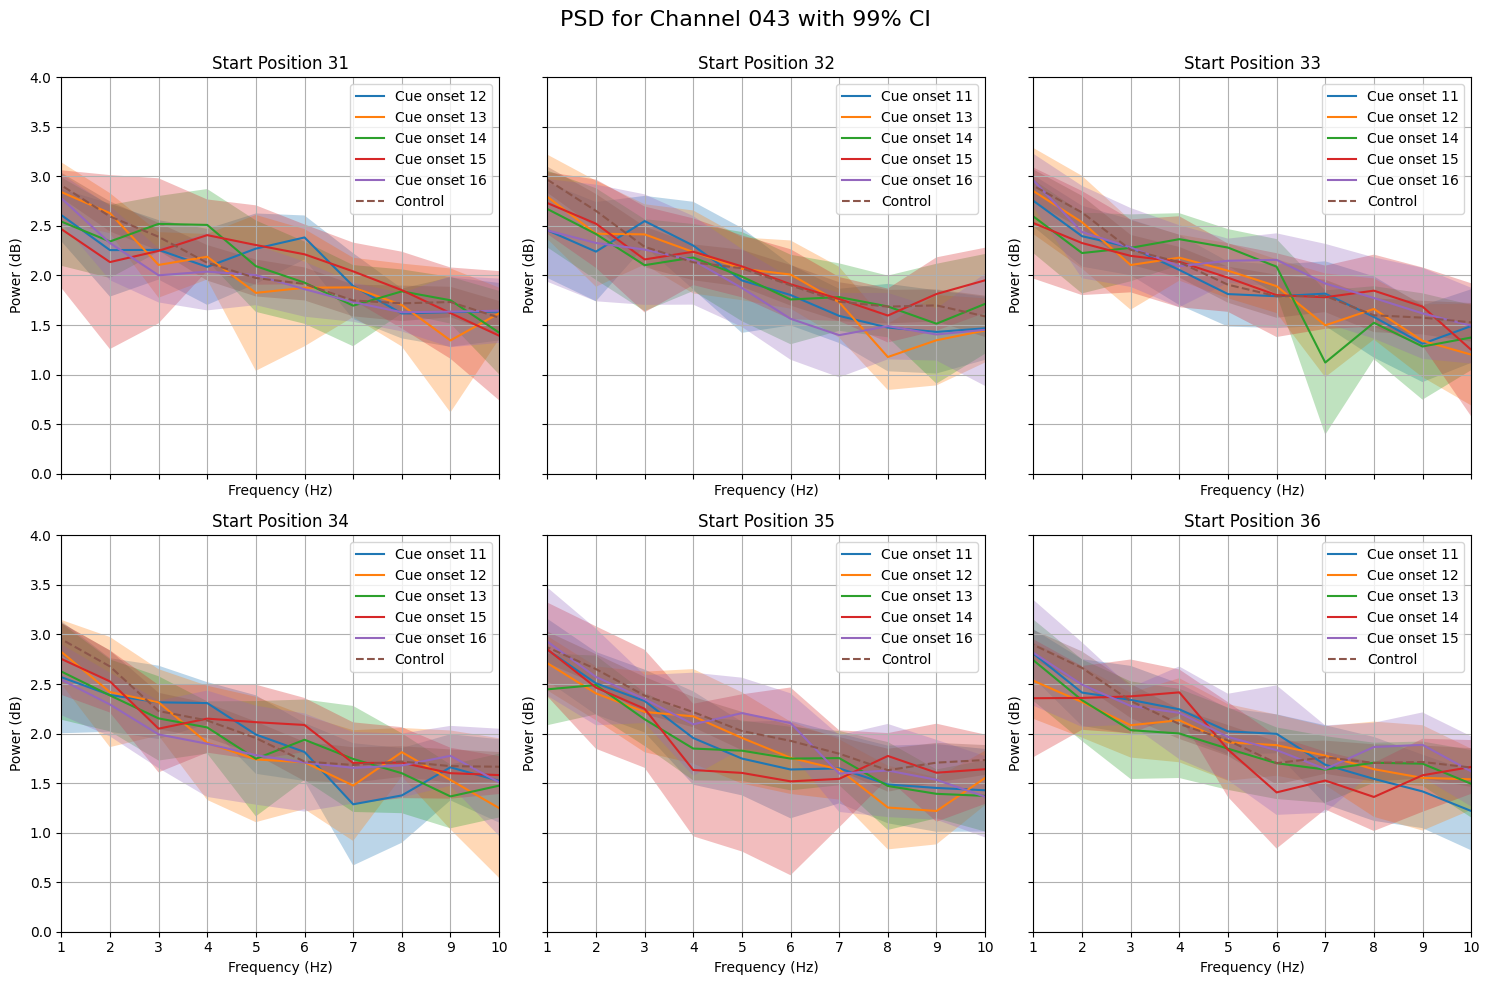

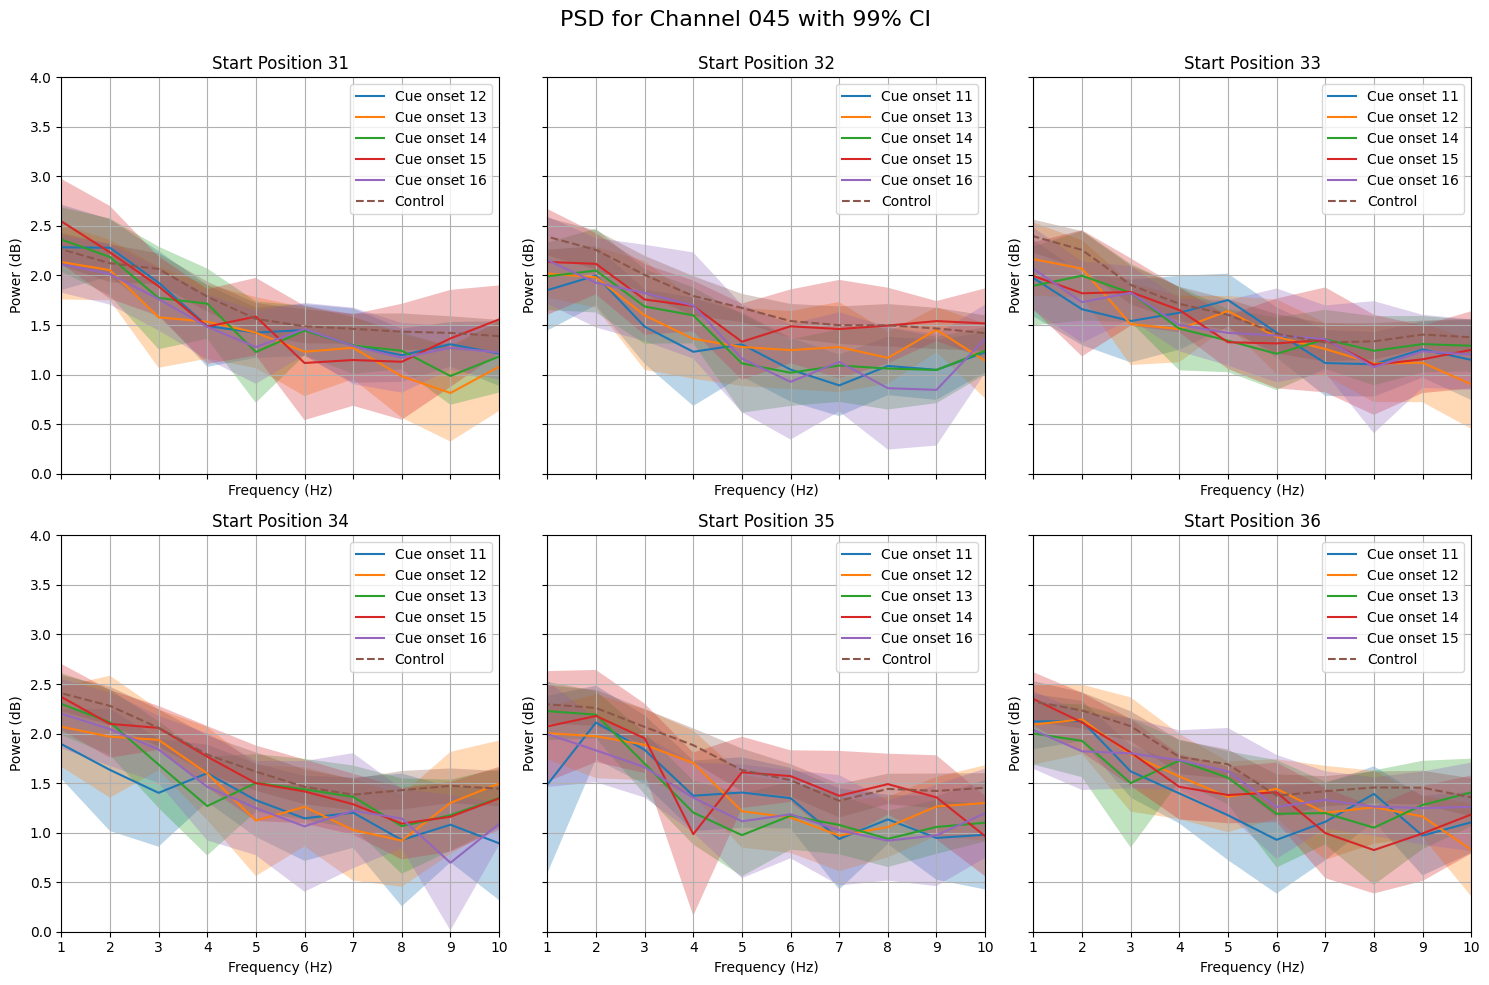

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# --- Preprocess: Convert channel values to zero-padded strings ---
cue_segments_df['channel'] = cue_segments_df['channel'].apply(lambda x: f"{int(x):03}")
control_segments_df['channel'] = control_segments_df['channel'].apply(lambda x: f"{int(x):03}")

# Create a sorted list of unique channel numbers from your cue data
channel_no = sorted(cue_segments_df['channel'].unique())

# --- Define your interesting channels dictionary and filter indices ---
interesting_ch = {
    '20181102' : [9,19,26,29,30,31,43,45],
    '20181105' : [19,23,29,30,43,45],
    '20181101' : [19,21,23,29,30,35,43,45],
    '20181031' : [19,26,29,30,35,43,45],
    '20181026' : [19,29,30,35,45],
    '20181022' : [9,17,26,29,43,45]
}
day = '20181105'  # Set the current day (must be a key in interesting_ch)

# Get indices of channels from channel_no that match the interesting channels for the given day
ch_indx = []
for i in interesting_ch[day]:
    ch_str = f"{i:03}"
    if ch_str in channel_no:
        ch_indx.append(channel_no.index(ch_str))

# --- Helper function to compute mean, SEM, and frequency vector from PSD arrays ---
def process_psd_arrays(data, key='psd'):
    psd_list = data[key].values
    if len(psd_list) == 0:
        return None, None, None
    # Determine the minimum length among arrays to allow stacking
    lengths = [arr.shape[0] for arr in psd_list if hasattr(arr, 'shape')]
    if not lengths:
        return None, None, None
    min_length = min(lengths)
    # Trim each array to the minimum length and stack them
    psd_stack = np.stack([arr[:min_length] for arr in psd_list])
    mean_val = psd_stack.mean(axis=0)
    sem_val = sem(psd_stack, axis=0)
    # Get the frequency vector from the first row (assumed identical across rows)
    freq = data.iloc[0]['freq'][:min_length]
    return mean_val, sem_val, freq

# --- Get unique start positions (assumed to be 6) ---
start_positions = sorted(cue_segments_df['start_position'].unique())

# --- Plotting loop: For each interesting channel, create a figure with 6 subplots ---
for ch in ch_indx:
    # Use the channel string from channel_no for filtering and display
    channel_str = channel_no[ch]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, start in enumerate(start_positions):
        ax = axes[i]

        # --- Plot Cue Data: One curve per cue onset ---
        cue_data = cue_segments_df[(cue_segments_df['channel'] == channel_str) &
                                   (cue_segments_df['start_position'] == start)]
        if not cue_data.empty and 'cue_onset' in cue_data.columns:
            for onset in sorted(cue_data['cue_onset'].unique()):
                data_onset = cue_data[cue_data['cue_onset'] == onset]
                mean_psd, sem_psd, freq = process_psd_arrays(data_onset, key='psd')
                if mean_psd is not None:
                    ci = 2.576 * sem_psd  # 99% Confidence Interval
                    ax.plot(freq, mean_psd, '-', label=f'Cue onset {onset}')
                    ax.fill_between(freq, mean_psd - ci, mean_psd + ci, alpha=0.3)

        # --- Plot Control Data: Aggregate over all entries (ignoring onset) ---
        control_data = control_segments_df[(control_segments_df['channel'] == channel_str) &
                                           (control_segments_df['start_position'] == start)]
        if not control_data.empty:
            mean_psd, sem_psd, freq = process_psd_arrays(control_data, key='psd')
            if mean_psd is not None:
                ci = 2.576 * sem_psd  # 99% Confidence Interval
                ax.plot(freq, mean_psd, '--', label='Control')
                ax.fill_between(freq, mean_psd - ci, mean_psd + ci, alpha=0.3)

        # Customize the subplot
        ax.set_title(f'Start Position {start}')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power (dB)')
        ax.set_xlim([1, 10])
        ax.set_ylim([0, 4])
        ax.legend(loc='upper right')
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f'PSD for Channel {channel_str} with 99% CI', fontsize=16)
    plt.show()


In [41]:
cue_segments_df.keys()

Index(['segment', 'channel', 'start_position', 'cue_onset', 'psd', 'freq',
       'peak_stds', 'peak_means', 'peak_gauss', 'flat_specs', 'flat_spec_og',
       'ap_fit_og', 'peaks', 'peak_freqs'],
      dtype='object')

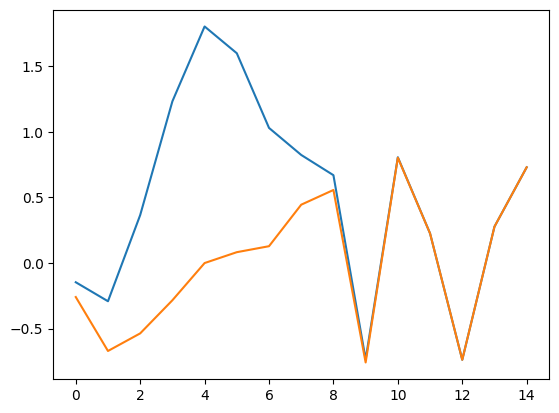

In [54]:
for i in cue_segments_df['flat_specs'][0]:
    plt.plot(i)